<a href="https://colab.research.google.com/github/thadd3us/ml_public/blob/main/CLIP_and_HuggingFace_CLIP_Preprocessing_Differences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I made this notebook to examine the differences between the HuggingFace implementation of CLIP and the version from OpenAI.

TL;DR: There are some small differences in the image processing.

Viewing this notebook in nbviewer lets you see the interactive plots:
https://nbviewer.org/github/thadd3us/ml_public/blob/main/CLIP_and_HuggingFace_CLIP_Preprocessing_Differences.ipynb

In [52]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3l6b0ldn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3l6b0ldn
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [53]:
# HuggingFace version comes with Colab.
from transformers import CLIPProcessor, CLIPModel

# CLIP version installed from GitHub.
import clip

import torch
import numpy as np
import PIL
import requests
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [54]:
# Change to "colab" to make the plot show up in Google Colab.
pio.renderers.default = "notebook"

In [55]:
hf_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
hf_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [56]:
clip_model, clip_preprocess = clip.load("ViT-L/14@336px")

In [57]:
clip_preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7a6957fc20e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [58]:
hf_processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  },
  "use_square_size": false
}

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=700x467 at 0x7A690F44DD80>


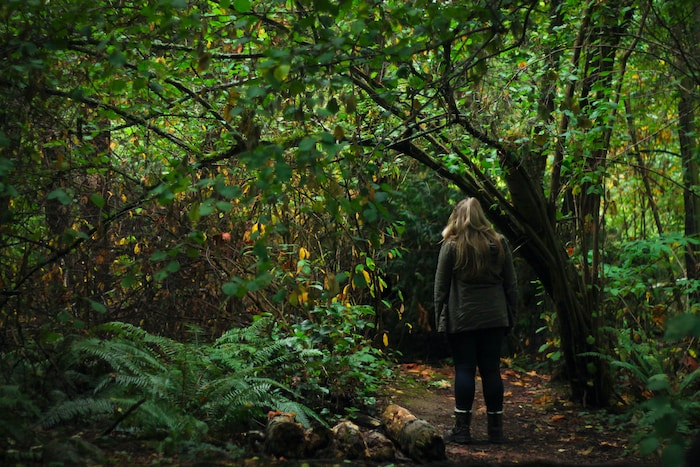

In [59]:
# Load an image from Unsplash.
url = 'https://images.unsplash.com/uploads/14119492946973137ce46/f1f2ebf3?w=700'
image = PIL.Image.open(requests.get(url, stream=True).raw)
print(image)
image

In [60]:
def display_rgb(rgb: np.ndarray) -> go.Figure:
  rgb = np.moveaxis(rgb, 0, -1)  # Channel to end.
  return px.imshow((rgb - rgb.min()) / (rgb.max() - rgb.min()))

In [61]:
hf_preprocessed = hf_processor.image_processor.preprocess(image)["pixel_values"][0]
print(hf_preprocessed.shape)  # Channel, Rows, Cols
fig = display_rgb(hf_preprocessed)
fig.update_layout(title="HuggingFace Preprocessed")
fig.show()


(3, 336, 336)


In [62]:
clip_preprocessed = clip_preprocess(image)
print(clip_preprocessed.shape)
fig = display_rgb(clip_preprocessed.numpy())
fig.update_layout(title="CLIP Preprocessed")

torch.Size([3, 336, 336])


In [63]:
# Highlights areas where the preprocessed pixels are different.
fig = display_rgb(clip_preprocessed.numpy() - hf_preprocessed)
fig.update_layout(title="Differnce: CLIP - HuggingFace")

In [64]:
# Another way to see the difference.
fig = display_rgb(np.abs(clip_preprocessed.numpy() - hf_preprocessed))
fig.update_layout(title="Abs Differnce: CLIP - HuggingFace")

In [65]:
with torch.no_grad():
  hf_embed = hf_model.get_image_features(torch.Tensor(hf_preprocessed).unsqueeze(0)).numpy()[0,:]
  clip_embed = clip_model.encode_image(clip_preprocessed.unsqueeze(0)).numpy()[0,:]
  hf_embed_clip_preprocess = clip_model.encode_image(torch.Tensor(hf_preprocessed).unsqueeze(0)).numpy()[0,:]

In [66]:
fig = px.scatter(x=hf_embed, y=clip_embed)
fig.update_traces(marker_size=2, marker_opacity=0.5)
fig.update_layout(
    title="Different preprocessing yields slight differences in embedding",
    xaxis_title="HF Embed Component",
    yaxis_title="CLIP Embed Component")

In [67]:
fig = px.scatter(x=hf_embed, y=hf_embed_clip_preprocess)
fig.update_traces(marker_size=2, marker_opacity=0.5)
fig.update_layout(
    title="But with the same preprocessing, the two models behave identically",
    xaxis_title="HF Embed Component",
    yaxis_title="HF Embed w/ CLIP preprocess")